# **librosa?**


> https://librosa.org/librosa/generated/librosa.feature.melspectrogram.html



In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
y, sr = librosa.load(librosa.util.example_audio_file())

In [ ]:
librosa.feature.melspectrogram(y=y, sr=sr)

array([[2.63330644e-07, 2.54545751e-03, 6.94285062e-02, ...,
        3.34132614e-08, 1.35390816e-08, 7.23030095e-10],
       [1.48204295e-07, 1.16257764e-02, 1.33231536e+00, ...,
        2.57257016e-07, 9.53164997e-08, 1.18527171e-09],
       [3.64170428e-07, 2.34068424e-02, 5.07212652e+00, ...,
        1.63250639e-06, 3.06545325e-07, 1.45464843e-09],
       ...,
       [3.65634363e-10, 2.85678891e-08, 2.12918571e-06, ...,
        2.84671318e-11, 7.83192729e-12, 1.15972642e-13],
       [1.95074737e-10, 9.91002192e-09, 6.60153368e-07, ...,
        7.60728008e-12, 2.06383002e-12, 2.43639214e-14],
       [8.62272286e-12, 2.35881969e-10, 4.41610791e-08, ...,
        6.06083903e-13, 1.94372364e-13, 3.81628595e-15]])

In [ ]:
 # Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

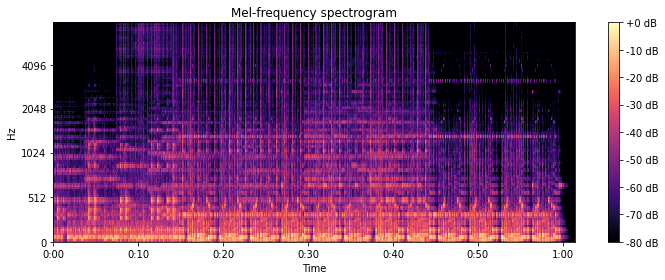

In [ ]:
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# **FSDD**


> https://github.com/Jakobovski/free-spoken-digit-dataset



In [ ]:
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3166 (delta 3), reused 8 (delta 3), pack-reused 3157
Receiving objects: 100% (3166/3166), 23.92 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (72/72), done.


**Import**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import librosa
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, isdir, join, splitext
import random
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datatype = torch.float

**Usefull methods and class**

In [ ]:
def add_samples(filepath, max_length):
  """Data Augmentation"""
  x, y = [], []
  samples, sample_rate = librosa.load(filepath)
  for ts in [0.75, 1, 1.25]:
    for ps in [-1, 0, +1]:
      size = sample_rate * max_length
      short_samples = librosa.util.fix_length(data = samples, size = int(size))
      samplesnew = librosa.effects.time_stretch(short_samples, rate = ts)
      ynew = librosa.effects.pitch_shift(samplesnew, sample_rate, n_steps = ps)
      x.append(samplesnew)
      y.append(ynew)
  return x, y 

def get_dataloader(wav_path, 
                max_length = 1.5, 
                n_samples = None, # number of samples
                seed = 1234,  
                test_ratio  = 0.1,
                valid_ratio = 0.1,
                batch_size = 64, # how many samples per batch to load (default: 1)
                shuffle = True, # set to True to have the data reshuffled at every epoch (default: False)
                num_workers = 8, # how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
                drop_last = False # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
                ) :

  """bulid dataloader"""

  assert isdir(wav_path)
  assert max_length > 0
  assert n_samples == None or n_samples > 0

  X, Y = [], []
  i = 0
  for filename in listdir(wav_path) :
    filepath = join(wav_path, filename)
    
    if isfile(filepath) and splitext(filename)[-1] == ".wav":
      x, y = add_samples(filepath = filepath, max_length = max_length)
      """
      for x_i, y_i in zip(x, y) :
        X.append(x_i) 
        Y.append(y_i)
        i = i + 1
      """
      X.append(x[0]) 
      Y.append(y[0])
      i = i + 1
    
    if n_samples <= i :
      break

  X = X[:n_samples]
  Y = Y[:n_samples]
  
  # transform to torch tensor
  X = torch.Tensor(X) 
  Y = torch.Tensor(Y)


  # random seeds for reproducibility
  #random.seed(seed)
  #np.random.seed(seed)
  #torch.manual_seed(seed)
  #torch.backends.cudnn.deterministic = True
 
  X,       X_test,  Y,       Y_test  = train_test_split(X, Y, test_size = test_ratio,  random_state=42)
  X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = valid_ratio, random_state=42)

  train_dataset = TensorDataset(X_train, Y_train) 
  test_dataset  = TensorDataset(X_test,  Y_test) 
  valid_dataset = TensorDataset(X_valid, Y_valid) 
  print(f'Number of training examples: {len(train_dataset)}')
  print(f'Number of validation examples: {len(valid_dataset)}')
  print(f'Number of testing examples: {len(test_dataset)}')

  train_loader = DataLoader(train_dataset, # dataset from which to load the data.
                        batch_size = batch_size, 
                        shuffle = shuffle, 
                        num_workers = num_workers, 
                        drop_last = drop_last 
                        )
  
  test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers, drop_last = drop_last)
  valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers, drop_last = drop_last)
 
  return train_loader, test_loader, valid_loader

class Model(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, output_dim)
    
  def forward(self, x):
    #x = x.view((-1,3072)) # Converts 2D data to 1D
    h = self.fc1(x)
    h = torch.relu(h)
    h = self.fc2(h)
    h = torch.relu(h)
    h = self.fc3(h)
    out = torch.log_softmax(h, dim=1)
    return out

class Trainer():
  """
    This class allows to do these four things :
    - define the model
    - compilation, which will load the data, build the optimizer and the loss function
    - training and testing the model. 
  """

  def __init__(self, model, dump_path = "/content"):
    """
    create the new instance of trainer
    model (subclass of nn.Module) : model concerned
    dump_path (string, default="") : folder in which the model will be saved during and after training
    """
    
    self.model = model
    if not os.path.exists(dump_path):
      os.makedirs(dump_path)
    self.dump_path = dump_path

  def compile(self, optimizer, criterion):
    self.optimizer = optimizer
    self.criterion = criterion
    self.count_parameters()

  def count_parameters(self):
    """print out the number of parameters in the model"""
    nb_p = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    print(f'The model has {nb_p:,} trainable parameters\n')

  def build_dataset(self, wav_path, max_length = 1.5, n_samples = 20):
    self.train_loader, self.test_loader, self.valid_loader = get_dataloader(
        wav_path = wav_path, 
        max_length = max_length, 
        n_samples = n_samples
    )

  def reload_model(self, dump_id=""):
    """
    Preloaded the parameters of an existing model
    dump_id : identifier to distinguish models in the serialization folder, 
              is by default equal to the name of the base model.
    """

    dump_id = dump_id if dump_id == "" else dump_id+'-'
    self.model.load_state_dict(torch.load(self.dump_path+"/"+dump_id+'best-model.pth')["model"])

  def train_step(self):

    self.model.train()
    array_loss = []

    for data, target in self.train_loader :
      # move samples to GPU/CPU
      data, target = data.to(device), target.to(device)
      
      #Cleargradients
      self.optimizer.zero_grad()
      
      # Forward Propagation
      y_pred = self.model(data)
      
      # Error Computation
      loss = self.criterion(y_pred, target)
      
      # Backpropagation
      loss.backward()
      
      # Parameter Update
      self.optimizer.step()

      array_loss.append(loss.item())

    return np.mean(array_loss)

  def eval(self, data_loader):
    
    self.model.eval()
    array_loss = []

    with torch.no_grad():
      for data, target in data_loader:
        # move samples to GPU/CPU
        data, target = data.to(device), target.to(device)
        y_pred = self.model(data)
        array_loss.append(self.criterion(y_pred, target).item())

    return np.mean(array_loss)

  def epoch_time(self, start_time, end_time):
    """
    Tell us how long epochs take, use to compare training times between models.
    start_time : start time of the epoch
    end_time : end time of the epoch
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

  def train(self, max_epochs = 100, improving_limit = 5, dump_id = ""):
    """
    We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.
        
    max_epochs (int, default = 100 ) : maximun number of epochs
    improving_limit (int, default = 5 ) : If the precision of the model does not 
                                          improve during `improving_limit` epoch, we 
                                          stop training and keep the best model.
    dump_id : identifier to distinguish models in the serialization folder, 
                  is by default equal to the name of the base model.
    
    At each epoch, if the validation loss is the best we have seen so far, we'll save the 
    parameters of the model and then after training has finished we'll use that model on the test set.
    """
    assert max_epochs > 0
    assert improving_limit >= 0

    best_loss = float("inf") # +infini
    dump_id = dump_id if dump_id == "" else dump_id+'-'
    no_best_model = 0

    statistics = {}
    statistics["epoch"] = []
    for i in ["train", "valid"] :
      statistics[i] = {}
      statistics[i]["loss"] = []

    for epoch in range(1, max_epochs + 1):
      
      start_time = time.time()
      
      train_loss = self.train_step()
      valid_loss = self.eval(self.valid_loader)
      statistics["epoch"].append(epoch)
      statistics['train']["loss"].append(train_loss)
      statistics['valid']["loss"].append(valid_loss)
      
      print(f"\t Epoch : {epoch} | Train Loss: {train_loss:.4f} |  Val. loss: {valid_loss:.4f} ============ ")

      end_time = time.time()
      epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

      if best_loss > valid_loss :
        best_loss =  valid_loss
        # save the best model parameters
        
        torch.save({"model":self.model.state_dict(), "best_loss":best_loss}, 
                   self.dump_path+"/"+dump_id+'best-model.pth')
        no_best_model = 0
        print("\t====== New best validation score")

      else :
        no_best_model += 1 
        print("\t====== Not a better validation score (%i / %i)." % (no_best_model, improving_limit))

      if no_best_model == improving_limit :
        break

    self.model.load_state_dict(torch.load(self.dump_path+"/"+dump_id+'best-model.pth')["model"]) 

    return statistics
    
  def test(self):
    test_loss = self.eval(self.test_loader)
    print(f"\t============ test_loss: {test_loss:.4f} ============ ")

  def plot_statistics(self, statistics, figsize=(15,3)):
    """
    https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
    https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
    """
    x = statistics["epoch"]

    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize = figsize)
    fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize = figsize)
    fig.suptitle('')

    ax1.plot(x, statistics['train']["loss"], label='train')
    ax1.plot(x, statistics['valid']["loss"], label='valid')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_title('loss per epoch')
    ax1.legend()
    ax1.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

**Train / Test**

In [ ]:
recordings_path = "/content/free-spoken-digit-dataset/recordings"

In [ ]:
trainer =  Trainer(model = None, dump_path = "/content")

In [ ]:
trainer.build_dataset(wav_path = recordings_path, max_length = 1.5, n_samples = 1000) # environ 13 000 exemples

Number of training examples: 810
Number of validation examples: 90
Number of testing examples: 100


In [ ]:
for data, target in trainer.train_loader:
  input_dim = data.size()[1]
  output_dim = target.size()[1]
  break

In [ ]:
trainer.model = Model(input_dim = input_dim, hidden_dim = 128, output_dim = output_dim)
trainer.model.to(device)

Model(
  (fc1): Linear(in_features=44032, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=44032, bias=True)
)

In [ ]:
optimizer = optim.Adam(trainer.model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='mean')
trainer.compile(optimizer = optimizer, criterion = criterion)

The model has 11,332,864 trainable parameters



In [ ]:
stats = trainer.train(max_epochs = 50, improving_limit = 5, dump_id = "test")

	 Epoch : 1 | Train Loss: 114.3322 |  Val. loss: 114.3257 ============ 
	====== New best validation score
	 Epoch : 2 | Train Loss: 114.3266 |  Val. loss: 114.3253 ============ 
	====== New best validation score
	 Epoch : 3 | Train Loss: 114.3249 |  Val. loss: 114.3252 ============ 
	====== New best validation score
	 Epoch : 4 | Train Loss: 114.3250 |  Val. loss: 114.3251 ============ 
	====== New best validation score
	 Epoch : 5 | Train Loss: 114.3249 |  Val. loss: 114.3251 ============ 
	====== New best validation score
	 Epoch : 6 | Train Loss: 114.3250 |  Val. loss: 114.3251 ============ 
	====== Not a better validation score (1 / 5).
	 Epoch : 7 | Train Loss: 114.3249 |  Val. loss: 114.3251 ============ 
	====== Not a better validation score (2 / 5).
	 Epoch : 8 | Train Loss: 114.3250 |  Val. loss: 114.3251 ============ 
	====== New best validation score
	 Epoch : 9 | Train Loss: 114.3249 |  Val. loss: 114.3251 ============ 
	====== Not a better validation score (1 / 5).
	 Epoch

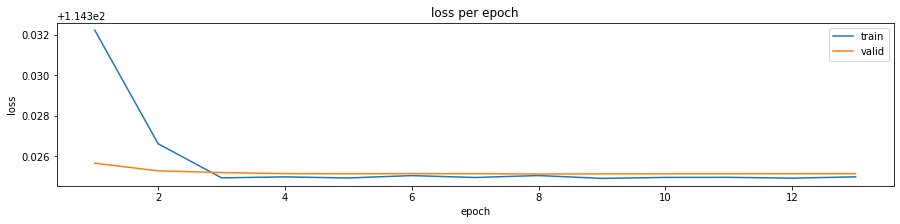

In [ ]:
trainer.plot_statistics(statistics = stats, figsize=(15,3))

In [ ]:
trainer.test()

	============ test_loss: 114.3245 ============ 
